**1. Import các thư viện cần thiết**

In [14]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error as msle

**2. Đọc file dữ liệu BID và chia dataset theo tỉ lệ 9:1**

In [15]:
# Đọc file dữ liệu
df = pd.read_csv('D:\BID.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.9 * len(df))
test_size = int(0.1 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


**Xem** **lại** **dataset**

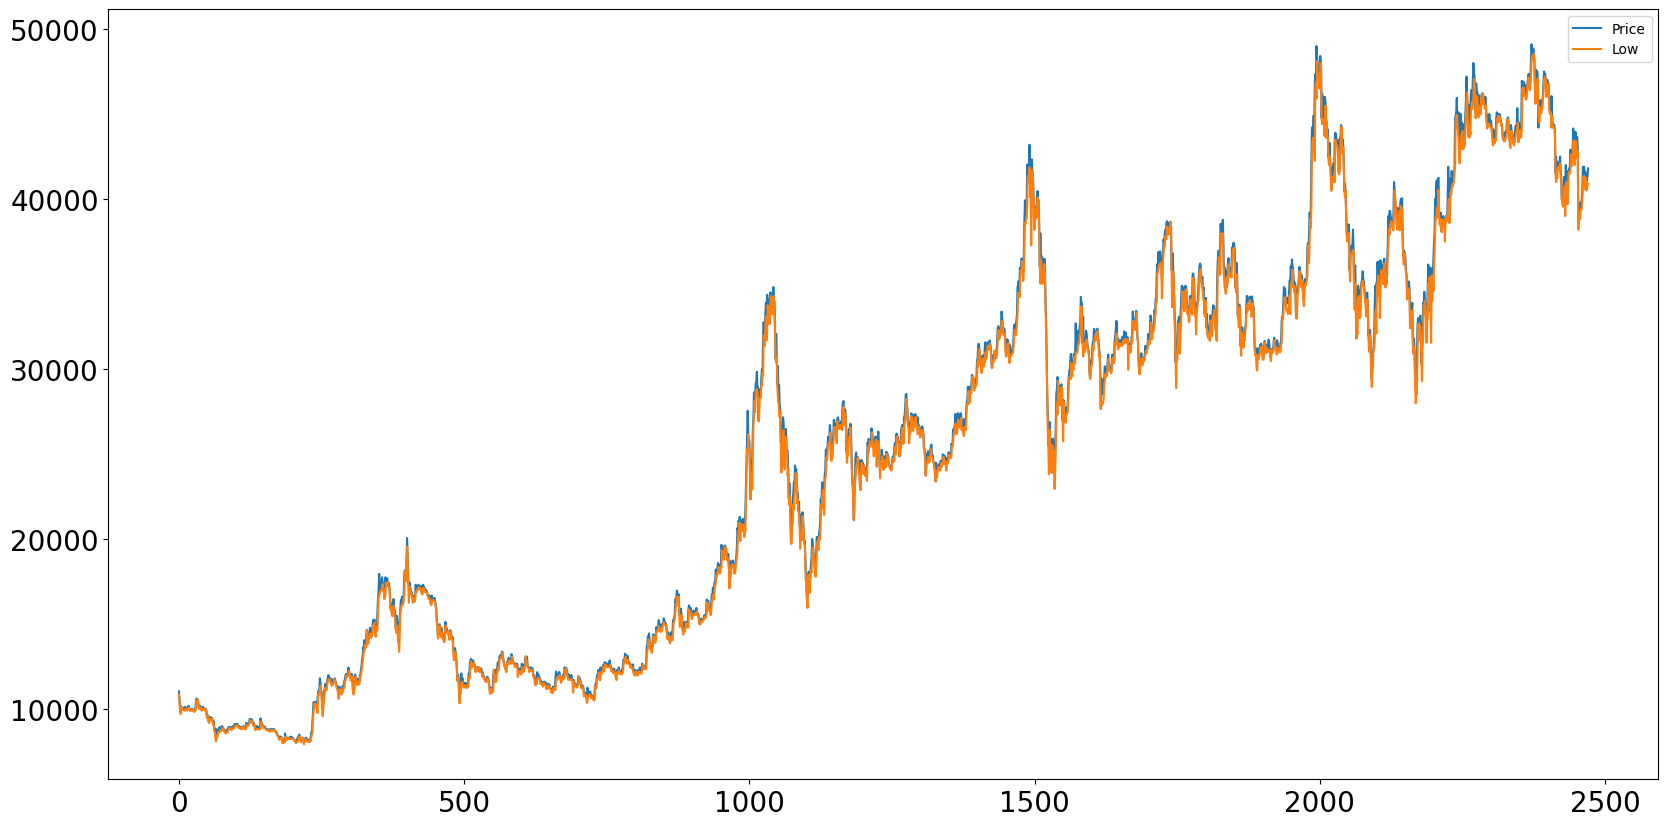

In [16]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [17]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.2112075330694403,
 0.6687560278478504,
 1,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 38486.18864029625)

In [18]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [19]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-51.3605244441914,
 0.0,
 0,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 38471.01317565339)

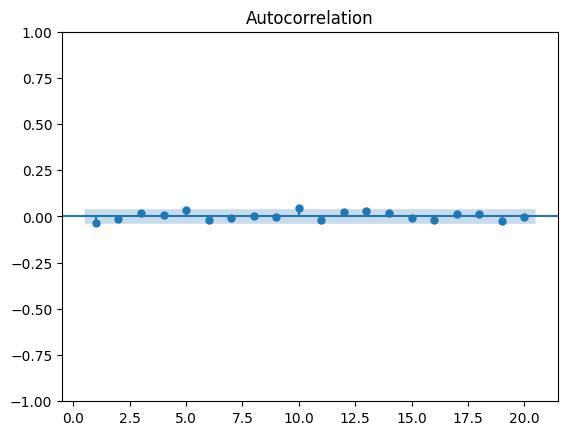

In [20]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [21]:
df

,Price,Low
0,11054.8,10874.6
1,10574.2,10574.2
2,9973.4,9913.3
3,10213.7,9733.1
4,10153.6,10153.6
...,...,...
2466,41500.0,41250.0
2467,41000.0,40500.0
2468,41200.0,40550.0
2469,41300.0,40800.0


In [22]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=34827.043, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=34828.040, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=34828.282, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=34825.980, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=34826.734, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=34826.967, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=34826.175, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=34828.378, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=34828.386, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=34830.370, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[5]          
Total fit time: 2.674 seconds


**Dùng SARIMAX để train model**

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(0,1,0), seasonal_order=(0,0,0,5))
model_fit = model1.fit()

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [24]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([38750., 38700., 39600., 40000., 38600., 39050., 40400., 40250.,
       40600., 40850., 40750., 40900., 41000., 41600., 41950., 44600.,
       44800., 44950., 44500., 44000., 43550., 42600., 42100., 43150.,
       42900., 43700., 43900., 44000., 42950., 42950., 43300., 43150.,
       44000., 44950., 45800., 46250., 45000., 43700., 44400., 43600.,
       44050., 43800., 45400., 45250., 45300., 45500., 45900., 47050.,
       46950., 46250., 44750., 45450., 46050., 46000., 45000., 44800.,
       45450., 45300., 45500., 45000., 46000., 45550., 46200., 46050.,
       45800., 45700., 45300., 45300., 45500., 44700., 44150., 44200.,
       44400., 44450., 44400., 44300., 44200., 44150., 44200., 43700.,
       43150., 43200., 43500., 43500., 43300., 43450., 43550., 44700.,
       44500., 44800., 44550., 44900., 44750., 44800., 44500., 44300.,
       44400., 43850., 43500., 43450., 43400., 43400., 43600., 43550.,
       43650., 44000., 44700., 44300., 44350., 43700., 43100., 43000.,
      

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [25]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[43101.02770396 43115.96313729 43130.89857062 43145.83400396
 43160.76943729 43175.70487062 43190.64030396 43205.57573729
 43220.51117062 43235.44660395 43250.38203729 43265.31747062
 43280.25290395 43295.18833728 43310.12377062 43325.05920395
 43339.99463728 43354.93007061 43369.86550395 43384.80093728
 43399.73637061 43414.67180395 43429.60723728 43444.54267061
 43459.47810394 43474.41353728 43489.34897061 43504.28440394
 43519.21983727 43534.15527061]


***7.Đánh giá độ chính xác thuật toán***

In [26]:
#MSLE
test_msle = msle(y_test, y_pred_test)
print('Testing MSLE:', test_msle)

#RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Testing MAE:', test_mae)

Testing MSLE: 0.00025848234064939724
Testing RMSE: 700.0072295751594
Testing MAPE: 1.0774573025084806
Testing MAE: 476.7206477732793


**8. Vẽ biểu đồ**

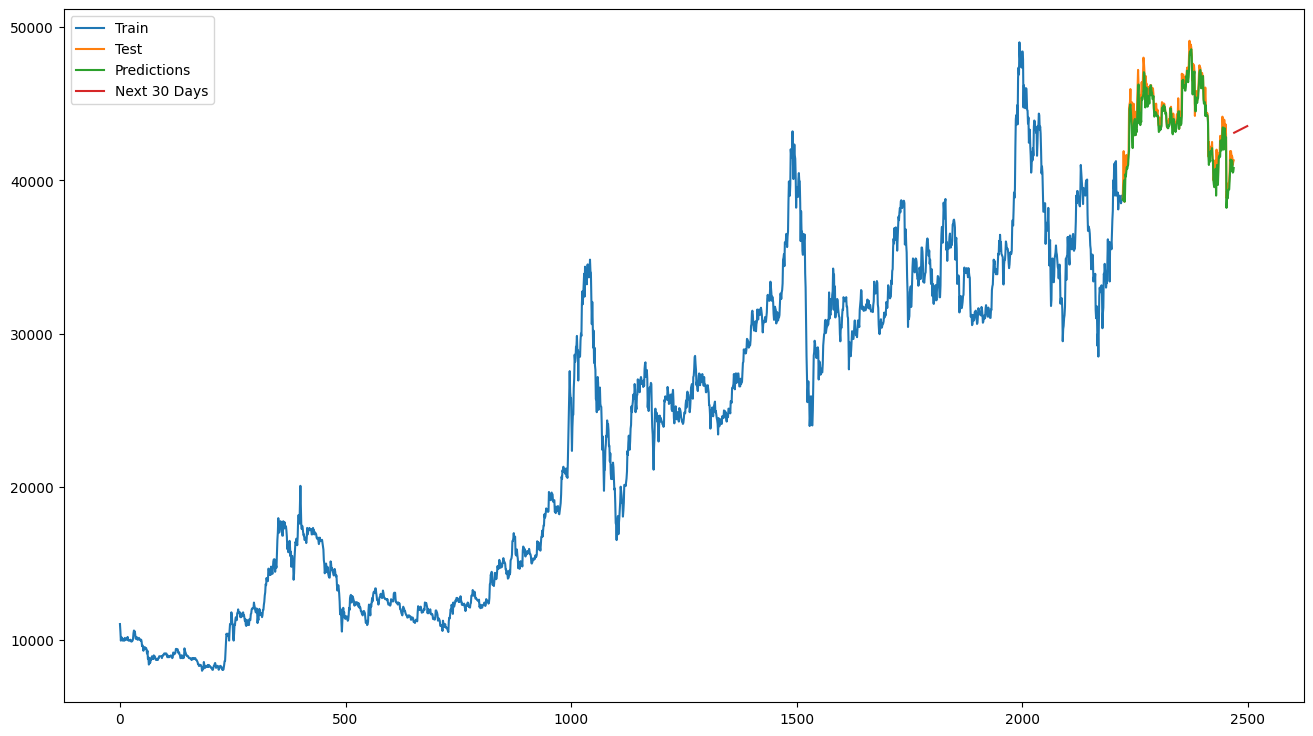

In [27]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next 30 Days'])
plt.show()